In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
counts = pd.read_csv('/content/Fremont_Bridge_Bicycle_Counter.csv', index_col='Date', parse_dates=True)
#weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [0]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

In [0]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

we might expect riders to behave differently on holidays; let's add an indicator of this as well:

In [0]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

We also might suspect that the hours of daylight would affect how many people ride; let's use the standard astronomical calculation to add this information:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(8.0, 17.0)

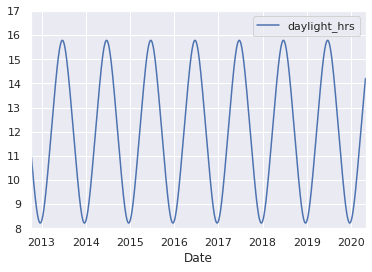

In [9]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

We can also add the average temperature and total precipitation to the data. In addition to the inches of precipitation, let's add a flag that indicates whether a day is dry (has zero precipitation):

In [10]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

NameError: ignored

In [0]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

displayurl:https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html

Now our data is in order, and we can take a look at it:

In [12]:
daily.head()


,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,annual
Date,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.000000
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.002740
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.005479
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.008219
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.010959


With this in place, we can choose the columns to use, and fit a linear regression model to our data. We will set fit_intercept = False, because the daily flags essentially operate as their own day-specific intercepts:

In [0]:
from sklearn.linear_model import LinearRegression
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

#column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
 #               'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

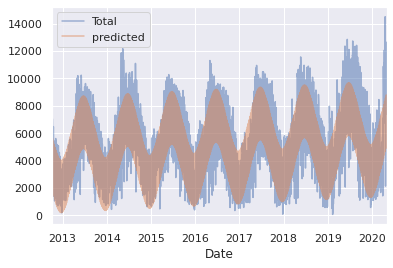

In [16]:
daily[['Total', 'predicted']].plot(alpha=0.5);


In [17]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon            -1340.613808
Tue            -1009.853820
Wed            -1056.888768
Thu            -1361.731256
Fri            -2009.207172
Sat            -4744.950901
Sun            -4835.673794
holiday        -1878.211487
daylight_hrs     609.503702
annual           160.047063
dtype: float64

These numbers are difficult to interpret without some measure of their uncertainty. We can compute these uncertainties quickly using bootstrap resamplings of the data:

In [0]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [19]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon          -1341.0  154.0
Tue          -1010.0  150.0
Wed          -1057.0  148.0
Thu          -1362.0  148.0
Fri          -2009.0  148.0
Sat          -4745.0  142.0
Sun          -4836.0  138.0
holiday      -1878.0  321.0
daylight_hrs   610.0   10.0
annual         160.0   15.0


We first see that there is a relatively stable trend in the weekly baseline: there are many more riders on weekdays than on weekends and holidays. We see that for each additional hour of daylight, 129 ± 9 more people choose to ride; a temperature increase of one degree Celsius encourages 65 ± 4 people to grab their bicycle; a dry day means an average of 548 ± 33 more riders, and each inch of precipitation means 665 ± 62 more people leave their bike at home. Once all these effects are accounted for, we see a modest increase of 27 ± 18 new daily riders each year.